In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
from wordcloud import WordCloud

In [2]:
# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Download for better lemmatization support
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/kostas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kostas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kostas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kostas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/kostas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Read dataset with pandas
depression = pd.read_csv('reddit_depression_dataset.csv')
#depression = pd.read_csv('./data/reddit_depression_dataset.csv')

/tmp/ipykernel_7030/75337162.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  depression = pd.read_csv('reddit_depression_dataset.csv')


My suggestion is that we should compress to gzip before reading it. Compress (in the terminal) and then read the compressed file

In [5]:
# Convert the dataset to tsv and compress it
depression.to_csv("reddit_depression_dataset.tsv.gz", sep='\t', index=False, compression='gzip')

In [3]:
# Read the compressed tsv file and display columns
depression = pd.read_csv('reddit_depression_dataset.tsv.gz', sep='\t')
print(depression.head())

/tmp/ipykernel_6635/3171313170.py:2: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  depression = pd.read_csv('reddit_depression_dataset.tsv.gz', sep='\t')


  Unnamed: 0     subreddit                                              title  \
0      47951  DeepThoughts                             Deep thoughts underdog   
1      47952  DeepThoughts  I like this sub, there's only two posts yet I ...   
2      47957  DeepThoughts                                           Rebirth!   
3      47959  DeepThoughts  "I want to be like water. I want to slip throu...   
4      47960  DeepThoughts                                          Who am I?   

                                                body  upvotes   created_utc  \
0  Only when we start considering ourselves, the ...      4.0  1.405309e+09   
1  Anyway: Human Morality is a joke so long as th...      4.0  1.410568e+09   
2  Hello. \nI am the new guy in charge here (Besi...      6.0  1.416458e+09   
3                                                NaN     25.0  1.416512e+09   
4  You could take any one cell in my body and kil...      5.0  1.416516e+09   

   num_comments  label  
0           N

In [12]:
# Display descriptive statistics for numerical columns
# Get an overview of the DataFrame, including counts of non-null entries per column and data types
print(depression.info())
print("-" * 50)  

# Some info about the column data
for column in depression.columns:
    unique_values = depression[column].unique()
    print(f"Column '{column}' has {len(unique_values)} unique values.")
    print(unique_values)
    print("-" * 50)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551065 entries, 0 to 4551064
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   subreddit     object 
 2   title         object 
 3   body          object 
 4   upvotes       float64
 5   created_utc   float64
 6   num_comments  float64
 7   label         float64
dtypes: float64(4), object(4)
memory usage: 277.8+ MB
None
--------------------------------------------------
Column 'Unnamed: 0' has 2471259 unique values.
['47951' '47952' '47957' ... 10742232 10742243 10742244]
--------------------------------------------------
Column 'subreddit' has 59 unique values.
['DeepThoughts' 'teenagers' '4.0' nan '32.0' '15' '23.0' '13.0' '33.0'
 '8.0' '26.0' '6' '30' '5' '6.0' '11.0' '12' '16' '7' '4' '61' '10' '7.0'
 '5.0' '15.0' '9' '29.0' '12.0' '17.0' '9.0' '8' '42.0' '107' '11' '10.0'
 '19.0' '18.0' 'happy' '146.0' '25.0' '22.0' 'SuicideWatch' '1402326041'
 '16.0' 'depression'

In [13]:
# Count of NaNs in each column
print(depression.isna().sum())

Unnamed: 0       803448
subreddit       1808267
title           1808270
body            2269302
upvotes         2080353
created_utc     2080535
num_comments    2194402
label           2080535
dtype: int64


### Preprocessing
1) Deal with NA values

In [14]:
# Drop rows where 'body' column is NaN or empty
depression = depression.dropna(subset=['body']).loc[depression['body'].str.strip() != '']

# I believe there is no reason to drop this one, but since they are only 9 rows, whatever
depression = depression.dropna(subset=['Unnamed: 0'])

# Drop rows where all columns except 'subreddit' and 'Unnamed: 0' are NaN
depression = depression.dropna(how='all', subset=[col for col in depression.columns if col not in ['subreddit', 'Unnamed: 0']])
print(depression.info())
print(depression.isna().sum())
print(len(depression['Unnamed: 0'].unique()))

<class 'pandas.core.frame.DataFrame'>
Index: 2280916 entries, 0 to 4551064
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   subreddit     object 
 2   title         object 
 3   body          object 
 4   upvotes       float64
 5   created_utc   float64
 6   num_comments  float64
 7   label         float64
dtypes: float64(4), object(4)
memory usage: 156.6+ MB
None
Unnamed: 0           0
subreddit            0
title                2
body                 0
upvotes         272085
created_utc     272253
num_comments    356458
label           272253
dtype: int64
2009018


In [15]:
# Replace NaN values in 'num_comments' column with 0
depression['num_comments'] = depression['num_comments'].fillna(0)

In [16]:
# Should we do the same with 'upvotes' ?
# Check if there is a 0 in the 'upvotes' column
has_zero = (depression['upvotes'] == 0).any()
print(has_zero)
#depression['upvotes'] = depression['upvotes'].fillna(0)

True


2. Deal with variable type and 'created_utc' variable

In [17]:
# We should convert the columns 'upvotes', 'num_comments' and 'label' to type int32
for column_name in ['upvotes', 'num_comments', 'label']:
    depression[column_name] = depression[column_name].astype('Int64')
print(depression.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2280916 entries, 0 to 4551064
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   subreddit     object 
 2   title         object 
 3   body          object 
 4   upvotes       Int64  
 5   created_utc   float64
 6   num_comments  Int64  
 7   label         Int64  
dtypes: Int64(3), float64(1), object(4)
memory usage: 163.1+ MB
None


In [18]:
# Convert UTC epoch time to human-readable time (as another column)
depression['created_datetime'] = pd.to_datetime(depression['created_utc'], unit='s')
print(depression[['created_datetime']].head())

# Drop 'created_utc' column
depression= depression.drop(columns=['created_utc']) 

     created_datetime
0 2014-07-14 03:35:09
1 2014-09-13 00:31:19
2 2014-11-20 04:31:58
4 2014-11-20 20:36:52
5 2014-11-22 19:17:39


In [18]:
# Split the data frame into target and features
y = depression['label'] 
X = depression.drop(columns=['label'])  # Feature matrix without 'label' column


### Language processing part

1. Make use of Computerome to apply MapReduce

The lemmatizer uses only the 'body' column which contains the actual text. We need to save our preprocessed data set on a tsv.gz file, upload it on Computerome and perform lemmatization in chunks there (use of many nodes and cores to parallelize). 

This is essential since the lemmatization of 10.000 entries takes ~2m to execute, so ~2.2m entries would take ~8h. 

To make the process even faster and smoother, instead of working with the whole data set, we create a subset containing only the 'body' column plus an identifier column in order to be possible to merge it back later.

Before that, we find that there are duplicated text values in the 'body' column. Some shorter phrases can be genuine post by different people (phrases like 'I need help') while longer ones might be actual duplicates that we want to discard.

In [19]:
import pandas as pd

# Define a word count threshold (e.g., 5 words)
word_count_threshold = 5

# Identify duplicates in the dataset
print("Identifying duplicates...")
duplicates_mask = depression['body'].duplicated(keep=False)

# Filter the original dataframe to get only duplicates
print("Extracting duplicate entries...")
duplicates = depression[duplicates_mask].copy()
print(f"Number of duplicate entries: {len(duplicates)}")

# Count words only in the duplicate entries
print("Counting words in duplicate entries...")
duplicates['word_count'] = duplicates['body'].str.split().str.len()

# Separate the duplicates into short and long ones based on word count
print("Separating short and long duplicates...")
short_duplicates = duplicates[duplicates['word_count'] <= word_count_threshold]
long_duplicates = duplicates[duplicates['word_count'] > word_count_threshold]
print(f"Number of short duplicates: {len(short_duplicates)}")
print(f"Number of long duplicates: {len(long_duplicates)}")

# Keep all short posts, including short duplicates
print("Filtering the dataset to keep all short posts...")

# Create a mask to keep non-duplicate rows or short duplicates
short_duplicate_indices = short_duplicates.index
keep_mask = (~duplicates_mask) | (depression.index.isin(short_duplicate_indices))

# Apply the mask to get the filtered DataFrame
depression_filtered = depression[keep_mask]

# For long posts, drop duplicates but keep the first occurrence
print("Handling long duplicates...")
depression_filtered_long = long_duplicates.drop_duplicates(subset='body', keep='first')

# Concatenate filtered data: keep all short posts and filtered long posts without duplicates
print("Combining short and filtered long posts...")
final_filtered_depression = pd.concat([depression_filtered, depression_filtered_long], ignore_index=True).drop_duplicates().reset_index(drop=True)

# Drop the 'word_count' column from final_filtered_depression if it exists
if 'word_count' in final_filtered_depression.columns:
    final_filtered_depression = final_filtered_depression.drop(columns=['word_count'])

# Output the final shape
print(f"Final filtered dataset shape: {final_filtered_depression.shape}")


Identifying duplicates...
Extracting duplicate entries...
Number of duplicate entries: 351117
Counting words in duplicate entries...
Separating short and long duplicates...
Number of short duplicates: 67229
Number of long duplicates: 283888
Filtering the dataset to keep all short posts...
Handling long duplicates...
Combining short and filtered long posts...
Final filtered dataset shape: (2000382, 8)


In [20]:
final_filtered_depression

,Unnamed: 0,subreddit,title,body,upvotes,num_comments,label,created_datetime
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4,0,0,2014-07-14 03:35:09
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4,1,0,2014-09-13 00:31:19
2,47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6,1,0,2014-11-20 04:31:58
3,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5,4,0,2014-11-20 20:36:52
4,47969,DeepThoughts,What is the limit of the knowledge and power a...,"Personally, I think it's infinite. We will alw...",8,23,0,2014-11-22 19:17:39
...,...,...,...,...,...,...,...,...
2000377,10370336,depression,[M/25] Is it even worth it anymore?,Hello and thanks for reading this.\n\nI'm sorr...,5,0,1,2020-12-15 21:45:22
2000378,10438776,depression,"Working with depression, the never ending sick...",Having to go to work everyday while depressed ...,7,8,1,2021-04-06 04:56:33
2000379,10449200,depression,"Hi, bye.",I just wanna fuckin die\n\nI just wanna feel a...,9,7,1,2021-04-24 18:29:30
2000380,10468508,depression,Writing a letter to depression,Hey! I wrote a post like this before and recei...,5,0,1,2021-05-30 15:54:57


After that, we can discard even more duplicates based on time interval between them being posted. We set this interval to one minute. GENERATES PROBLEM - I DIDNT USE THAT

In [20]:
# Ensure 'created_datetime' is in datetime format
final_filtered_depression['created_datetime'] = pd.to_datetime(final_filtered_depression['created_datetime'])

# Sort the dataframe by 'body' and 'created_datetime'
depression_sorted = final_filtered_depression.sort_values(by=['body', 'created_datetime']).reset_index(drop=True)

# Define a time threshold to determine likely accidental duplicates (e.g., 2 hours)
time_threshold = pd.Timedelta(seconds=30)

# Create an empty list to hold the indexes of rows to keep
indexes_to_keep = []

# Group the dataframe by 'body' to identify duplicates
for body, group in depression_sorted.groupby('body'):
    if len(group) == 1:
        # If there is only one post with this body, keep it
        indexes_to_keep.extend(group.index)
    else:
        # More than one post, compare timestamps
        previous_time = None
        for idx, row in group.iterrows():
            if previous_time is None:
                # Keep the first post and set previous_time
                indexes_to_keep.append(idx)
                previous_time = row['created_datetime']
            else:
                # Calculate the time difference
                time_diff = row['created_datetime'] - previous_time
                if time_diff > time_threshold:
                    # If time difference is greater than the threshold, keep the post
                    indexes_to_keep.append(idx)
                # Update previous_time to current post's time
                previous_time = row['created_datetime']

# Create a new dataframe containing only the posts we want to keep
filtered_depression = depression_sorted.loc[indexes_to_keep].reset_index(drop=True)

# Print the filtered dataframe info
print(f"Filtered dataset shape: {filtered_depression.shape}")

Filtered dataset shape: (2001080, 8)


Prepare the file to be submitted to Computerome for MapReduce

In [21]:
# Reset the index of the DataFrame
final_filtered_depression.reset_index(drop=True, inplace=True)
# Add a unique identifier
final_filtered_depression['unique_id'] = final_filtered_depression.index

# Define a function to perform all the replacements (tab and multiple spaces) in one go
# Their existence could potentially create problems during the process on Computerome
def clean_text(text):
    return re.sub(r'\s+', ' ', re.sub(r'[\n\t]', ' ', text))

# Apply the function to the 'body' column
final_filtered_depression['body'] = final_filtered_depression['body'].apply(lambda x: clean_text(x) if isinstance(x, str) else x)

# Verify the count of tab characters in the 'body' column before saving
tab_count = final_filtered_depression['body'].apply(lambda x: x.count('\t')).sum()
print(f"Number of tab characters in 'body' column: {tab_count}")

# Verify the count of multiple continuous spaces in the 'body' column before saving
multiple_spaces_count = final_filtered_depression['body'].apply(lambda x: len(re.findall(r'\s{2,}', x))).sum()
print(f"Number of occurrences of multiple continuous spaces in 'body' column: {multiple_spaces_count}")

# Select the necessery columns
depression_computerome = final_filtered_depression[['body', 'unique_id']]

# Write to a file
depression_computerome.to_csv("preprocessed_depression_dataset_full.tsv.gz", sep='\t', index=False, compression='gzip', header=False)

Number of tab characters in 'body' column: 0
Number of occurrences of multiple continuous spaces in 'body' column: 0


In [22]:
final_filtered_depression

,Unnamed: 0,subreddit,title,body,upvotes,num_comments,label,created_datetime,unique_id
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4,0,0,2014-07-14 03:35:09,0
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4,1,0,2014-09-13 00:31:19,1
2,47957,DeepThoughts,Rebirth!,Hello. I am the new guy in charge here (Beside...,6,1,0,2014-11-20 04:31:58,2
3,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5,4,0,2014-11-20 20:36:52,3
4,47969,DeepThoughts,What is the limit of the knowledge and power a...,"Personally, I think it's infinite. We will alw...",8,23,0,2014-11-22 19:17:39,4
...,...,...,...,...,...,...,...,...,...
2000377,10370336,depression,[M/25] Is it even worth it anymore?,Hello and thanks for reading this. I'm sorry f...,5,0,1,2020-12-15 21:45:22,2000377
2000378,10438776,depression,"Working with depression, the never ending sick...",Having to go to work everyday while depressed ...,7,8,1,2021-04-06 04:56:33,2000378
2000379,10449200,depression,"Hi, bye.",I just wanna fuckin die I just wanna feel alri...,9,7,1,2021-04-24 18:29:30,2000379
2000380,10468508,depression,Writing a letter to depression,Hey! I wrote a post like this before and recei...,5,0,1,2021-05-30 15:54:57,2000380


In [23]:
depression_computerome

,body,unique_id
0,"Only when we start considering ourselves, the ...",0
1,Anyway: Human Morality is a joke so long as th...,1
2,Hello. I am the new guy in charge here (Beside...,2
3,You could take any one cell in my body and kil...,3
4,"Personally, I think it's infinite. We will alw...",4
...,...,...
2000377,Hello and thanks for reading this. I'm sorry f...,2000377
2000378,Having to go to work everyday while depressed ...,2000378
2000379,I just wanna fuckin die I just wanna feel alri...,2000379
2000380,Hey! I wrote a post like this before and recei...,2000380


The following chunks of code were executed on Computerome on three scripts.
1) The administrator, which split the initial file
2) The workers, which performed the computations
3) The collector, which collected every output file to the final output file

Two jobscripts were used to submit 
a) The administrator-worker part
b) The collector part

For the whole process, we made use of the functions get_wordnet_pos (to identify the nature of the word - noun, verb etc.) and the process_text_pos (enhanced process_text to make use od the get_wordnet_pos function).

In [18]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [19]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [20]:
# Updated preprocess_text function with POS tagging
def preprocess_text_pos(text):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize and remove stopwords
    words = word_tokenize(text)  # Use word_tokenize for proper tokenization
    words = [word for word in words if word not in stopwords.words('english')]
    
    # POS tag the words
    pos_tags = pos_tag(words)
    
    # Lemmatize each word with the correct POS tag
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    
    # Join words back to a single string
    return ' '.join(lemmatized_words)

In [21]:
# Define the custom preprocessing function with lemmatization
def preprocess_text(text):
    # Convert to lowercase and remove punctuation and continuous whitespaces
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back to a single string
    return ' '.join(lemmatized_words)

In [ ]:
# Apply preprocessing and skip empty results
#X['cleaned_body'] = X['body'].iloc[:10000].apply(lambda x: preprocess_text_pos(x) if preprocess_text_pos(x).strip() else x)
#depression_computerome['cleaned_body'] = depression_computerome['body'].apply(lambda x: preprocess_text_pos(x) if (temp := preprocess_text_pos(x)).strip() else x)
#depression_computerome.to_csv("preprocessed_depression_dataset.tsv.gz", sep='\t', index=False, compression='gzip', header=False)

,body,unique_id,cleaned_body
0,Anyway: Human Morality is a joke so long as th...,1,anyway human morality joke long abscence hope ...
1,Hello. I am the new guy in charge here (Beside...,2,hello new guy charge besides thegood ofc bring...
2,You could take any one cell in my body and kil...,3,could take one cell body kill would still yet ...
3,"Personally, I think it's infinite. We will alw...",4,personally think infinite always grow
4,"Hello, from now to Christmas we will be hostin...",5,hello christmas host contest ever post best in...
...,...,...,...
9994,I just want to see people's opinions. Let's sa...,9995,want see people opinion let say advanced class...
9995,"I've only been to one and it was pretty sweet,...",9996,one pretty sweet look new band go see summer e...
9996,So i've never been in a proper relationship be...,9997,never proper relationship try explain well see...
9997,"Hey guys (and gals!). Ok, basically a new girl...",9998,hey guy gal ok basically new girl move school ...


After the operations are done, we load the file back in and we merged it back to get the full data frame.

In [ ]:
# Load the dataset without headers
#depression_computerome_processed = pd.read_csv('final_cleaned_dataset.tsv.gz', sep='\t', compression='gzip', header=None)

# Add the headers
#depression_computerome_processed.columns = ['body', 'unique_id', 'cleaned_body']

# Merge back to the original dataframe
merged_df = final_filtered_depression.merge(depression_computerome_processed[['unique_id', 'cleaned_body']], on='unique_id', how='left')
merged_df
#merged_df.to_csv("merged.tsv.gz", sep='\t', index=False, compression='gzip', header=True)

,Unnamed: 0,subreddit,title,body,upvotes,num_comments,label,created_datetime,unique_id,cleaned_body
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4,0,0,2014-07-14 03:35:09,0,start consider 99 underdog begin value start root
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4,1,0,2014-09-13 00:31:19,1,anyway human morality joke long abscence hope ...
2,47957,DeepThoughts,Rebirth!,Hello. I am the new guy in charge here (Beside...,6,1,0,2014-11-20 04:31:58,2,hello new guy charge besides thegood ofc bring...
3,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5,4,0,2014-11-20 20:36:52,3,could take one cell body kill would still yet ...
4,47969,DeepThoughts,What is the limit of the knowledge and power a...,"Personally, I think it's infinite. We will alw...",8,23,0,2014-11-22 19:17:39,4,personally think infinite always grow
...,...,...,...,...,...,...,...,...,...,...
2000377,10370336,depression,[M/25] Is it even worth it anymore?,Hello and thanks for reading this. I'm sorry f...,5,0,1,2020-12-15 21:45:22,2000377,hello thanks read sorry wall text get 25 year ...
2000378,10438776,depression,"Working with depression, the never ending sick...",Having to go to work everyday while depressed ...,7,8,1,2021-04-06 04:56:33,2000378,go work everyday depress like work feel weathe...
2000379,10449200,depression,"Hi, bye.",I just wanna fuckin die I just wanna feel alri...,9,7,1,2021-04-24 18:29:30,2000379,wan na fuckin die wan na feel alright see fine...
2000380,10468508,depression,Writing a letter to depression,Hey! I wrote a post like this before and recei...,5,0,1,2021-05-30 15:54:57,2000380,hey write post like receive wonderful reply ba...


: 

In [26]:
# Convert non-string values in 'cleaned_body' to empty strings and handle NA values that may have been generated
merged_df['cleaned_body'] = merged_df['cleaned_body'].fillna('').astype(str)

THE NEXT BLOCK CRASHES DUE TO THE SIZE OF THE STRING GENERATED

In [1]:
# Combine all preprocessed text into a single string for word cloud generation
text_for_wordcloud = ' '.join(merged_df['cleaned_body'])

NameError: name 'merged_df' is not defined

In [142]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

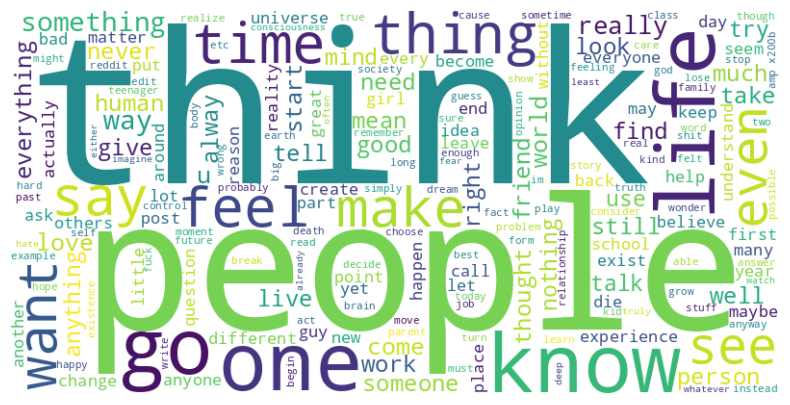

,Unnamed: 0,subreddit,title,body,upvotes,num_comments,created_datetime
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4,0,2014-07-14 03:35:09
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4,1,2014-09-13 00:31:19
2,47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6,1,2014-11-20 04:31:58
4,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5,4,2014-11-20 20:36:52
5,47969,DeepThoughts,What is the limit of the knowledge and power a...,"Personally, I think it's infinite. We will alw...",8,23,2014-11-22 19:17:39
...,...,...,...,...,...,...,...
4551060,10742224,depression,Alone as usual,I just argued with my mom an hour ago; she alw...,9,6,2022-12-31 23:30:10
4551061,10742230,depression,Help needed urgently!,OK basically non of my friend's or family invi...,5,7,2022-12-31 23:39:16
4551062,10742232,depression,I know what your thinking,Don't do It. Not today. Its gonna be ok if you...,10,8,2022-12-31 23:41:28
4551063,10742243,depression,how do I stop having such a cynical view on ma...,"So I don't know, I've recently realized that t...",8,9,2022-12-31 23:56:57


In [150]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
X

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Make a copy to avoid SettingWithCopyWarning and limit to the first 999 rows for consistency
X = X.iloc[:999].copy()
y = y.iloc[:999].copy()

In [ ]:
# Train-validation-test split with an 80-10-10 ratio
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Verify the split sizes
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

In [ ]:
from datasketch import MinHash
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from collections import Counter

In [ ]:
# Define MinHash parameters
num_perm = 1000  # Number of hash functions

In [ ]:
# Function to apply MinHashing
def minhash_vectorize(text, num_perm=1000):
    minhash = MinHash(num_perm=num_perm)
    for word in text.split():
        minhash.update(word.encode('utf8'))
    return np.array(minhash.hashvalues)

In [ ]:
# Apply MinHash vectorization to the cleaned_body in X_train and X_val
X_train['minhash_vector'] = X_train['cleaned_body'].apply(lambda x: minhash_vectorize(x, num_perm))
X_val['minhash_vector'] = X_val['cleaned_body'].apply(lambda x: minhash_vectorize(x, num_perm))

In [ ]:
# Stack the MinHash vectors into a 2D array for KMeans input
minhash_vectors_train = np.vstack(X_train['minhash_vector'].values)
minhash_vectors_val = np.vstack(X_val['minhash_vector'].values)

In [ ]:
# Define and fit the KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(minhash_vectors_train)

In [ ]:
# Assign each training review to a cluster
X_train['cluster'] = kmeans.labels_

In [ ]:
# Map each cluster to the most frequent sentiment in that cluster
cluster_to_sentiment = {}
for cluster in range(3):
    cluster_labels = y_train[X_train['cluster'] == cluster]
    most_common_sentiment = Counter(cluster_labels).most_common(1)[0][0]
    cluster_to_sentiment[cluster] = most_common_sentiment

In [ ]:
# Predict the clusters for the validation set
val_clusters = kmeans.predict(minhash_vectors_val)

In [ ]:
# Map the clusters to sentiments based on training data cluster assignments
y_val_pred = [cluster_to_sentiment[cluster] for cluster in val_clusters]

In [ ]:
# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation accuracy:", accuracy)

In [ ]:
# Print cluster composition to examine the distribution of sentiments in clusters
for cluster in range(3):
    print(f"Cluster {cluster} composition:", Counter(y_train[X_train['cluster'] == cluster]))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# Reduce MinHash vectors to 2D for visualization
pca = PCA(n_components=2)
train_vectors_2d = pca.fit_transform(minhash_vectors_train)

In [ ]:
# Plot the clusters with different colors
plt.figure(figsize=(10, 7))
for cluster in range(3):
    cluster_points = train_vectors_2d[X_train['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

In [ ]:
plt.title('KMeans Clusters of MinHash Vectors (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# Initialize CountVectorizer with binary=True for one-hot encoding
vectorizer = CountVectorizer(binary=True)

In [ ]:
# Fit on training data and transform both training and validation data
X_train_oh = vectorizer.fit_transform(X_train['cleaned_body'])
X_val_oh = vectorizer.transform(X_val['cleaned_body'])

In [ ]:
# Define and fit the KMeans model with 3 clusters on the one-hot encoded training data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_oh)

In [ ]:
# Assign each training review to a cluster
X_train['cluster'] = kmeans.labels_

In [ ]:
# Map each cluster to the most frequent sentiment in that cluster
cluster_to_sentiment = {}
for cluster in range(3):
    cluster_labels = y_train[X_train['cluster'] == cluster]
    most_common_sentiment = Counter(cluster_labels).most_common(1)[0][0]
    cluster_to_sentiment[cluster] = most_common_sentiment

In [ ]:
# Predict the clusters for the validation set
val_clusters = kmeans.predict(X_val_oh)

In [ ]:
# Map the clusters to sentiments based on training data cluster assignments
y_val_pred = [cluster_to_sentiment[cluster] for cluster in val_clusters]

In [ ]:
# Calculate and print accuracy
accuracy_train = accuracy_score(y_train, [cluster_to_sentiment[cluster] for cluster in kmeans.labels_])
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Training accuracy:", accuracy_train)
print("Validation accuracy:", accuracy_val)

In [ ]:
# Plotting the clusters for training data
# Reduce the dimensionality for visualization using PCA
pca = PCA(n_components=2)
train_vectors_2d = pca.fit_transform(X_train_oh.toarray())  # Convert sparse matrix to dense for PCA

In [ ]:
plt.figure(figsize=(10, 7))
for cluster in range(3):
    cluster_points = train_vectors_2d[X_train['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

In [ ]:
plt.title('KMeans Clusters of One-Hot Encoded Vectors (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()